In [1]:
import mysql.connector as sql
import pandas as pd
import datetime as dt
import numpy as np
from sorted_months_weekdays import *
from sort_dataframeby_monthorweek import *
import matplotlib.pyplot as plt
import math

In [2]:
db_connection = sql.connect(host='localhost', database='collection_visits', user='pandas', password='password')

pensCheckouts = pd.read_sql('SELECT * FROM PensCheckouts', con=db_connection)
pensCheckouts['start'] = pd.to_datetime(pensCheckouts['start'], unit='s').dt.tz_localize('utc').dt.tz_convert('US/Eastern')
pensCheckouts['start'].replace(0, np.nan, inplace=True)
pensCheckouts['end'].replace(0, np.nan, inplace=True)
pensCheckouts['end'] = pd.to_datetime(pensCheckouts['end'], unit='s').dt.tz_localize('utc').dt.tz_convert('US/Eastern')
pensCheckouts['start_ip'].replace(0, np.nan, inplace=True)
pensCheckouts['end_ip'].replace(0, np.nan, inplace=True)
pensCheckouts['start_ip'] = pensCheckouts['start_ip'].astype('category')
pensCheckouts['end_ip'] = pensCheckouts['end_ip'].astype('category')

pensCheckouts.set_index('id', inplace=True)
pensCheckouts.sort_index(inplace=True)
###DROPED COLUMNS####
pensCheckouts.drop(['start_ip', 'end_ip'], axis=1, inplace=True)

In [3]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 50)

In [5]:
pensCheckouts.describe()

,pen_id,visit_id
count,5.563370e+05,5.563370e+05
mean,1.540842e+06,1.054608e+08
std,2.064411e+05,2.996087e+07
min,0.000000e+00,7.934010e+05
25%,1.521293e+06,9.319917e+07
50%,1.522895e+06,1.128671e+08
75%,1.524479e+06,1.248006e+08
max,3.860073e+06,1.328067e+08


## how many checkout per time 

In [6]:
pensCheckouts.count()
#556337 checkout in total

pen_id      556337
visit_id    556337
start       556337
end         536811
dtype: int64

In [7]:
pensCheckouts['pen_id'].value_counts()
#what pen was used the most

1525511    826
1519959    721
1523121    717
1521555    715
1523605    670
          ... 
1520261      1
1523533      1
1520381      1
1521241      1
1526871      1
Name: pen_id, Length: 3032, dtype: int64

In [8]:
most_used_pens = pensCheckouts['pen_id'].value_counts()
most_used_pens = most_used_pens.to_frame().reset_index().rename({'index': 'pen_id', 'pen_id': 'time_used'}, axis=1)
most_used_pens

,pen_id,time_used
0,1525511,826
1,1519959,721
2,1523121,717
3,1521555,715
4,1523605,670
...,...,...
3027,1520261,1
3028,1523533,1
3029,1520381,1
3030,1521241,1


In [9]:
pensCheckouts.groupby(['pen_id']).size().nlargest(10)

pen_id
1525511    826
1519959    721
1523121    717
1521555    715
1523605    670
1524943    667
1521201    666
1520443    655
1521453    647
1524693    634
dtype: int64

/Users/shirin/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1102: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


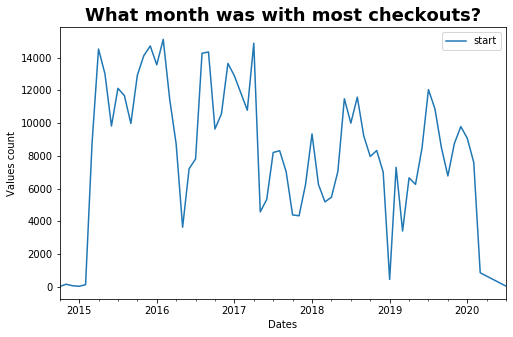

In [4]:
checkout_by_month = pensCheckouts['start'].groupby(pensCheckouts.start.dt.to_period("M")).agg('count')

plt.figure(figsize=(8,5))
plt.title('What month was with most checkouts?', fontdict={'fontweight': 'bold', 'fontsize':18})
checkout_by_month.plot()
plt.xlabel('Dates')
plt.ylabel('Values count')
plt.legend()
# plt.savefig('monthly_checkouts.png', dpi=300)
#most active between 2015-2017

In [13]:
checkout_by_month.nlargest()
#the most active months

start
2016-02    15110
2017-04    14874
2015-12    14705
2015-04    14520
2016-09    14339
Freq: M, Name: start, dtype: int64

In [11]:
pensCheckouts['start'].groupby(pensCheckouts.start.dt.to_period("M")).agg('count').nsmallest(10)
#January 2019 was the weakest after the start of the project and before covid19
#will be interesting to compare it to events / exhibitions at the same time / months

start
2014-10      20
2015-01      30
2020-07      36
2014-12      63
2015-02     126
2014-11     154
2019-01     447
2020-03     854
2019-03    3404
2016-05    3643
Freq: M, Name: start, dtype: int64

/Users/shirin/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1102: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


Text(0, 0.5, 'Values percentage')

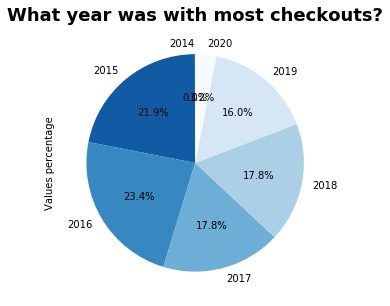

In [84]:
checkout_by_year = pensCheckouts['start'].groupby(pensCheckouts.start.dt.to_period("Y")).agg('count')

plt.figure(figsize=(8,5))
plt.title('What year was with most checkouts?', fontdict={'fontweight': 'bold', 'fontsize':18})
checkout_by_year.plot.pie(y='start', figsize=(5, 5),autopct='%1.1f%%', startangle=90, cmap='Blues_r')
plt.ylabel('Values percentage')
# plt.savefig('yearly_checkouts.png', dpi=300)

#2016 + 2015 were the most popular years
#2017 +2018 were the same
#2019 decreased in almost 2%

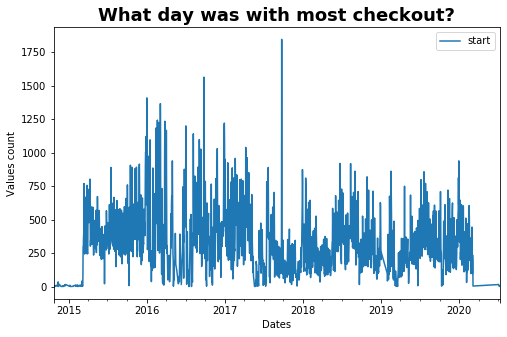

In [4]:
checkout_by_day = pensCheckouts['start'].groupby(pensCheckouts.start.dt.to_period("D")).agg('count')

plt.figure(figsize=(8,5))
plt.title('What day was with most checkout?', fontdict={'fontweight': 'bold', 'fontsize':18})
checkout_by_day.plot()
plt.xlabel('Dates')
plt.ylabel('Values count')
plt.legend()

In [5]:
pensCheckouts['start'].groupby(pensCheckouts.start.dt.to_period("D")).agg('count').nlargest()

start
2017-09-23    1845
2016-09-24    1563
2016-01-02    1408
2016-03-05    1365
2016-02-20    1242
Freq: D, Name: start, dtype: int64

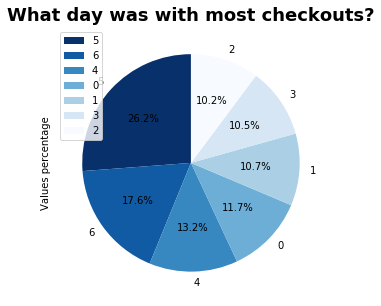

In [6]:
popular_days = pensCheckouts['start'].groupby(pensCheckouts.start.dt.weekday).agg('count').sort_values(ascending=False)

plt.figure(figsize=(8,5))
plt.title('What day was with most checkouts?', fontdict={'fontweight': 'bold', 'fontsize':18})
popular_days.plot.pie(y='start', figsize=(5, 5),autopct='%1.1f%%', startangle=90, cmap='Blues_r')
plt.ylabel('Values percentage')
plt.legend()
# plt.savefig('yearly_checkouts.png', dpi=300)

In [28]:
popular_days

start
5    142236
6    101501
4     73152
0     64990
1     59556
3     58218
2     56684
Name: start, dtype: int64

## zooming into particular time
### London September 2016

In [5]:
#Zooming into London 2016
start_date = '2016-09-07'
end_date = '2016-09-27'
mask = (pensCheckouts['start'] > start_date) & (pensCheckouts['start'] <= end_date)
london = pensCheckouts.loc[mask]
london

,pen_id,visit_id,start,end
id,,,,
108526123,1520095,108526121,2016-09-07 13:36:50,2016-09-07 13:36:55
108526125,1523789,108526121,2016-09-07 13:37:37,2016-09-07 13:38:24
108526127,1521533,108526121,2016-09-07 13:39:22,2016-09-07 13:39:31
108526129,1524309,108526121,2016-09-07 13:39:40,2016-09-07 13:39:49
108526131,1521323,108526121,2016-09-07 13:40:18,2016-09-07 13:40:43
...,...,...,...,...
109031123,1521361,109031121,2016-09-26 21:18:27,2016-09-26 21:41:23
109031127,1526877,109031125,2016-09-26 21:18:38,2016-09-26 21:41:19
109031131,1523131,109031129,2016-09-26 21:18:48,2016-09-26 21:40:55


In [9]:
london.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8854 entries, 108526123 to 109031139
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   pen_id    8854 non-null   int64         
 1   visit_id  8854 non-null   int64         
 2   start     8854 non-null   datetime64[ns]
 3   end       8854 non-null   datetime64[ns]
dtypes: datetime64[ns](2), int64(2)
memory usage: 665.9 KB


### Adam timeframe (January - July 2019)

In [29]:
#zooming to Adam timeframe 
start_date = '01-01-2019'
end_date = '07-31-2019'
mask = (pensCheckouts['start'] > start_date) & (pensCheckouts['start'] <= end_date)
sevenMonths = pensCheckouts.loc[mask]
sevenMonths

,pen_id,visit_id,start,end
id,,,,
126533273,1525671,126533271,2019-01-01 14:59:21,2019-01-01 14:59:59
126533283,1522073,126533281,2019-01-01 15:03:55,2019-01-01 17:10:08
126533543,1523883,126533535,2019-01-01 15:06:59,2019-01-01 16:55:44
126533727,1520165,126533721,2019-01-01 15:08:39,2019-01-01 17:07:43
126533763,1525239,126533753,2019-01-01 15:08:54,2019-01-01 17:09:13
...,...,...,...,...
129006279,1522407,129006277,2019-07-30 20:41:33,2019-07-30 21:39:45
129006283,1524941,129006281,2019-07-30 20:41:47,2019-07-30 21:39:15
129006777,1520651,129006775,2019-07-30 20:53:11,2019-07-30 20:53:30


In [30]:
sevenMonths.count()
#inbetween Adams time frame: 44,249 checkouts

pen_id      44249
visit_id    44249
start       44249
end         41865
dtype: int64

## what is the average time for pen uses

In [31]:
pensCheckouts[['start', 'end']]

,start,end
id,,
68762351,2014-10-23 15:36:51,2014-10-25 00:44:42
68762353,2014-10-23 16:25:42,2014-10-25 00:44:42
68764535,2014-10-24 02:04:59,2014-10-25 00:44:42
68764585,2014-10-24 15:05:23,2014-10-27 17:53:29
68764655,2014-10-25 00:02:19,2014-10-27 17:53:29
...,...,...
132777685,2020-07-02 20:22:28,2020-07-02 20:22:44
132794703,2020-07-06 17:42:18,2020-07-06 17:43:00
132806721,2020-07-09 13:12:28,2020-07-09 13:12:46


In [32]:
pensCheckouts['time_spent'] = pensCheckouts['end'] - pensCheckouts['start']
less_day = pensCheckouts['time_spent'] < '1day'
pensCheckouts[less_day]

# def mask_time(time):
#     pensCheckouts['time_spent'] = pensCheckouts['end'] - pensCheckouts['start']
#     less_time = pensCheckouts['time_spent'] < time
#     return pensCheckouts[less_time]

# mask_time('1day')

,pen_id,visit_id,start,end,time_spent
id,,,,,
68764535,9,793527,2014-10-24 02:04:59,2014-10-25 00:44:42,22:39:43
68765453,7,795317,2014-10-29 23:32:39,2014-10-29 23:42:20,00:09:41
68765467,8,795341,2014-10-29 23:40:54,2014-10-29 23:42:10,00:01:16
68765513,1,795405,2014-10-30 00:13:50,2014-10-30 00:15:08,00:01:18
68765521,1,795417,2014-10-30 00:16:53,2014-10-30 00:21:26,00:04:33
...,...,...,...,...,...
132777685,1520099,132777683,2020-07-02 20:22:28,2020-07-02 20:22:44,00:00:16
132794703,1520099,132794701,2020-07-06 17:42:18,2020-07-06 17:43:00,00:00:42
132806721,1520099,132806719,2020-07-09 13:12:28,2020-07-09 13:12:46,00:00:18


In [33]:
less_day_df = pensCheckouts[less_day]
less_day_df.sort_values(['time_spent']).head(20)
#there is a lot of goofy data

,pen_id,visit_id,start,end,time_spent
id,,,,,
68774043,3,814815,2014-11-12 17:40:42,2014-11-12 17:40:42,00:00:00
68802389,1509677,1509689,2014-12-15 15:07:56,2014-12-15 15:07:56,00:00:00
68775359,3,905243,2014-11-13 20:20:51,2014-11-13 20:20:51,00:00:00
68775357,3,904949,2014-11-13 20:15:55,2014-11-13 20:15:55,00:00:00
68775355,3,904839,2014-11-13 20:14:04,2014-11-13 20:14:04,00:00:00
68777557,987051,1050199,2014-11-19 20:04:19,2014-11-19 20:04:19,00:00:00
68775353,3,904639,2014-11-13 20:10:20,2014-11-13 20:10:20,00:00:00
68774045,3,815709,2014-11-12 17:57:15,2014-11-12 17:57:15,00:00:00
68775135,3,836101,2014-11-13 00:02:56,2014-11-13 00:02:56,00:00:00


In [34]:
less_day_df['time_spent'].mean()
#this is an average time with all the goofy times. now let's get rid of that----

Timedelta('0 days 02:02:31.281114')

In [35]:
less_day_df['time_spent'].median()

Timedelta('0 days 01:30:50')

In [36]:
min_spent = less_day_df["time_spent"].map(lambda timedelta: timedelta.total_seconds() / 60)
min_spent = min_spent.dropna().map(lambda seconds: math.floor(seconds))
min_spent = min_spent.to_frame()
min_spent

,time_spent
id,
68764535,1359
68765453,9
68765467,1
68765513,1
68765521,4
...,...
132777685,0
132794703,0
132806721,0


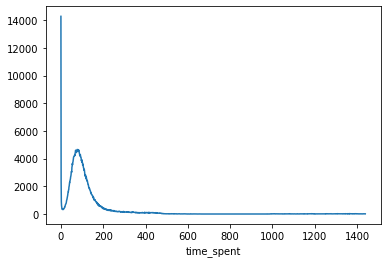

In [37]:
min_spent.groupby('time_spent').size().plot()
#crazy numbers with a few seconds only

In [38]:
less_five = min_spent[min_spent['time_spent'] > 5]
less_five['time_spent'].mean()
#calculating only visits above 5 minutes - the average time for the whole db is about 2hours and 7 min

126.90362885266111

In [23]:
#zooming to Adam timeframe 
start_date = '01-01-2019'
end_date = '07-31-2019'
mask = (less_day_df['start'] > start_date) & (less_day_df['start'] <= end_date)
seven_average_time = less_day_df.loc[mask]
seven_average_time

,pen_id,visit_id,start,end,time_spent
id,,,,,
126533273,1525671,126533271,2019-01-01 14:59:21,2019-01-01 14:59:59,00:00:38
126533283,1522073,126533281,2019-01-01 15:03:55,2019-01-01 17:10:08,02:06:13
126533543,1523883,126533535,2019-01-01 15:06:59,2019-01-01 16:55:44,01:48:45
126533727,1520165,126533721,2019-01-01 15:08:39,2019-01-01 17:07:43,01:59:04
126533763,1525239,126533753,2019-01-01 15:08:54,2019-01-01 17:09:13,02:00:19
...,...,...,...,...,...
129006279,1522407,129006277,2019-07-30 20:41:33,2019-07-30 21:39:45,00:58:12
129006283,1524941,129006281,2019-07-30 20:41:47,2019-07-30 21:39:15,00:57:28
129006777,1520651,129006775,2019-07-30 20:53:11,2019-07-30 20:53:30,00:00:19


In [24]:
seven_average_time.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40659 entries, 126533273 to 129006907
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype          
---  ------      --------------  -----          
 0   pen_id      40659 non-null  int64          
 1   visit_id    40659 non-null  int64          
 2   start       40659 non-null  datetime64[ns] 
 3   end         40659 non-null  datetime64[ns] 
 4   time_spent  40659 non-null  timedelta64[ns]
dtypes: datetime64[ns](2), int64(2), timedelta64[ns](1)
memory usage: 1.9 MB


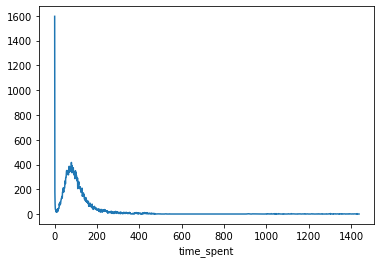

In [25]:
time_range = seven_average_time['time_spent'] < '1 days'
range_in_min = seven_average_time[time_range]
min_by_date = range_in_min["time_spent"].map(lambda timedelta: timedelta.total_seconds() / 60)
min_by_date = min_by_date.dropna().map(lambda seconds: math.floor(seconds))
min_by_date = min_by_date.to_frame()
min_by_date.groupby('time_spent').size().plot()

In [26]:
above_fivemin = min_by_date[min_by_date['time_spent'] > 5]
above_fivemin['time_spent'].mean()
#average time of greater than 5 min visits

119.26680797167008

## what pens were checkout the most? 

In [27]:
pensCheckouts['pen_id'].value_counts()

1525511    826
1519959    721
1523121    717
1521555    715
1523605    670
          ... 
1520261      1
1523533      1
1520381      1
1521241      1
1526871      1
Name: pen_id, Length: 3032, dtype: int64

In [24]:
pensCheckouts.groupby('pen_id').size().nlargest(10)

pen_id
1525511    826
1519959    721
1523121    717
1521555    715
1523605    670
1524943    667
1521201    666
1520443    655
1521453    647
1524693    634
dtype: int64

In [25]:
pensCheckouts.groupby('pen_id').size().nsmallest(10)

pen_id
1509671    1
1509675    1
1509679    1
1520261    1
1520375    1
1520381    1
1520391    1
1520665    1
1520931    1
1521241    1
dtype: int64

(array([-500000.,       0.,  500000., 1000000., 1500000., 2000000.,
        2500000., 3000000., 3500000., 4000000., 4500000.]),
 <a list of 11 Text xticklabel objects>)

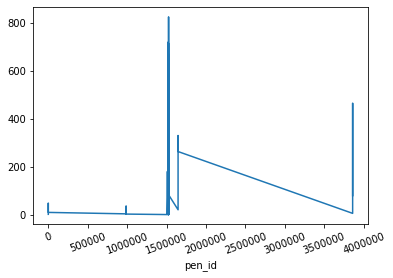

In [39]:
pensCheckouts.groupby('pen_id').size().plot()
plt.xticks(rotation=20)

## how many ppl used the pen?

In [42]:
pensCheckouts['visit_id'].value_counts().count()
#what does it means repeat visit_id?

544582

In [41]:
pensCheckouts[~pensCheckouts['visit_id'].duplicated()]

,pen_id,visit_id,start,end,time_spent
id,,,,,
68762351,8,793401,2014-10-23 15:36:51,2014-10-25 00:44:42,1 days 09:07:51
68762353,3,793449,2014-10-23 16:25:42,2014-10-25 00:44:42,1 days 08:19:00
68764535,9,793527,2014-10-24 02:04:59,2014-10-25 00:44:42,0 days 22:39:43
68764585,2,793571,2014-10-24 15:05:23,2014-10-27 17:53:29,3 days 02:48:06
68764655,7,793681,2014-10-25 00:02:19,2014-10-27 17:53:29,2 days 17:51:10
...,...,...,...,...,...
132777685,1520099,132777683,2020-07-02 20:22:28,2020-07-02 20:22:44,0 days 00:00:16
132794703,1520099,132794701,2020-07-06 17:42:18,2020-07-06 17:43:00,0 days 00:00:42
132806721,1520099,132806719,2020-07-09 13:12:28,2020-07-09 13:12:46,0 days 00:00:18


# how many Pens along the years

In [8]:
pensCheckouts2015 = pensCheckouts[pensCheckouts['start'].dt.year == 2015]
pensCheckouts2015['pen_id'].nunique()

1694

In [9]:
pensCheckouts2016 = pensCheckouts[pensCheckouts['start'].dt.year == 2016]
pensCheckouts2016['pen_id'].nunique()

2179

In [10]:
pensCheckouts2017 = pensCheckouts[pensCheckouts['start'].dt.year == 2017]
pensCheckouts2017['pen_id'].nunique()

1498

In [11]:
pensCheckouts2018 = pensCheckouts[pensCheckouts['start'].dt.year == 2018]
pensCheckouts2018['pen_id'].nunique()

1536

In [12]:
pensCheckouts2019 = pensCheckouts[pensCheckouts['start'].dt.year == 2019]
pensCheckouts2019['pen_id'].nunique()

915

In [93]:
total_pens= [{2015: 1694, 2016: 2179, 2017: 1498, 2018: 1536, 2019: 915}]

pens_in_years = pd.DataFrame(total_pens)
pens_in_years = pens_in_years.transpose()

In [69]:
pens_in_years['year'] = pd.to_datetime(pens_in_years['year']).dt.to_period('Y')

In [76]:
# checkout_by_year = checkout_by_year.to_frame()
checkout_by_year = checkout_by_year.rename({'start': 'count'}, axis=1)

In [82]:
checkout_by_year = checkout_by_year[['year', 'count']]

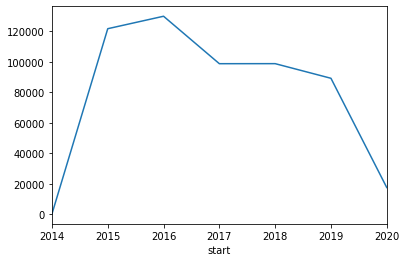

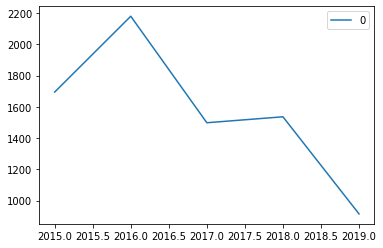

In [87]:
# pens_checkouts_merge = checkout_by_year.merge(pens_in_years, how='inner')
# pens_checkouts_merge.plot()
checkout_by_year.plot()
pens_in_years.plot()

## summerize findings

In [6]:
findings = [{'total_checkouts': '556,337', 'how_many_visitors_used_the_pen': '544,582', 'the_most_used_pen': 1525511, 'the_most_checkout_in_months': '2016-02 with 15,110 checkouts',
             'by_year': '2016', 'by_day': 'saturday', 'median_time_use': '90 minutes', 'average_time_use': '127 minutes'},
           {'the_most_used_pen': 1519959, 'the_most_checkout_in_months': '2017-04 with 14,874 checkouts', 'by_year': '2015',
           'by_day': 'sunday'},
           {'the_most_used_pen': 1523121, 'the_most_checkout_in_months': '2015-12 with 14,705 checkouts', 'by_year': '2017',
           'by_day': 'friday'}] 


checkout_finding = pd.DataFrame(findings)

In [7]:
checkout_finding.transpose()

,0,1,2
total_checkouts,"556,337",NaN,NaN
how_many_visitors_used_the_pen,"544,582",NaN,NaN
the_most_used_pen,1525511,1519959,1523121
the_most_checkout_in_months,"2016-02 with 15,110 checkouts","2017-04 with 14,874 checkouts","2015-12 with 14,705 checkouts"
by_year,2016,2015,2017
by_day,saturday,sunday,friday
median_time_use,90 minutes,NaN,NaN
average_time_use,127 minutes,NaN,NaN
